<a href="https://colab.research.google.com/github/KimYongHwi/dacon/blob/main/korea_east_west_power/korea_east_west_power.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [배경]

태양광 발전은 매일 기상 상황과 계절에 따른 일사량의 영향을 받습니다.

이에 대한 예측이 가능하다면 보다 원활한 전력 수급 계획이 가능합니다.

인공지능 기반 태양광 발전량 예측 모델을 만들어주세요.

## [평가]

- 심사 기준: NMAE-10(Normalized Mean Absolute Error)

- Public 평가: 학습용 제공 데이터를 이용하여 미래 한 달간 발전량 예측 후 평가

- Private 평가: 대회 종료 시점부터 30일간 실제 발전량을 하루씩 평가

- 1일 1회 채점 후 누적 결과 리더보드 반영

- Private 평가 기간 제출물 업데이트 가능 (※제출 후 선택 파일 확인을 반드시 해주시기 바랍니다.)

## [외부 데이터 및 사전학습 모델]

- 예측일 전날 자정까지 확인이 가능한 데이터만 학습 및 추론 과정에서 사용 가능

```
ex) 2021년 6월 11일 예측 -> 2021년 6월 10일 24:00까지 획득 가능한 데이터만 사용
(6월 10일 기상 관측 정보, 6월10일에 예보한 6월 11일 예보 등...)
```

- 예측 이전 시점의 데이터만 사용 가능

- 공공데이터와 같이 누구나 얻을 수 있고 법적 제약이 없는 외부 데이터 허용

- 사전학습 모델의 경우 사전학습에 사용된 데이터를 명시해야함

- 대회 진행 중 data leakage 및 규칙 위반 사항이 의심되는 경우 코드 제출 요청을 할 수 있으며 요청 2일 이내 코드 미제출 혹은 외부 데이터 사용이 확인되었을 경우 리더보드 기록 삭제

- 최종 평가시 외부데이터 및 출처 제출

## [유의 사항]

- 1일 최대 제출 횟수: 3회
- 사용 가능 언어: Python, R
- 모델 학습에서 검증 혹은 평가 데이터셋 활용 시(Data Leakage 등) 실격
- 최종 순위는 선택된 파일 중에서 채점되므로 참가자는 제출 창에서 자신이 최종적으로 채점 받고 싶은 파일을 선택해야 함
- 대회 직후 공개되는 Private 랭킹은 최종 순위가 아니며 코드 검증 후 수상자가 결정됨
- 데이콘은 부정 제출 행위를 금지하고 있으며 데이콘 대회 부정 제출 이력이 있는 경우 평가가 제한됩니다. 자세한 사항은 아래의 링크를 참고해 주시기 바랍니다. https://dacon.io/notice/notice/13

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from functools import reduce

In [ ]:
folder = "dacon"
project_dir = "korea_east_west_power"

base_path = Path("/content/drive/My Drive/")
project_path = base_path / folder / project_dir
os.chdir(project_path)

for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])

print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /content/drive/My Drive/dacon/korea_east_west_power


In [ ]:
dangjin_fcst_df = pd.read_csv('./data/dangjin_fcst_data.csv')
dangjin_obs_df = pd.read_csv('./data/dangjin_obs_data.csv')
energy_df = pd.read_csv('./data/energy.csv')
site_info_df = pd.read_csv('./data/site_info.csv')
ulsan_fcst_df = pd.read_csv('./data/ulsan_fcst_data.csv')
ulsan_obs_df = pd.read_csv('./data/ulsan_obs_data.csv')
sample_submission_df = pd.read_csv('./data/sample_submission.csv')

In [ ]:
# test_energy_df = energy_df.copy()
# test_dangjin_fcst_df = dangjin_fcst_df.copy()

# test_dangjin_fcst_df['Forecast_time'] = pd.to_datetime(test_dangjin_fcst_df['Forecast time'])
# test_dangjin_fcst_14 = test_dangjin_fcst_df[test_dangjin_fcst_df['Forecast_time'].dt.hour==14]
# test_dangjin_fcst_14 = test_dangjin_fcst_14[(test_dangjin_fcst_14['forecast']>=10)&(test_dangjin_fcst_14['forecast']<=33)]
# test_dangjin_fcst_14

# def to_date(x):
#     return pd.DateOffset(hours=x)

# test_dangjin_fcst_14['Forecast_time'] = test_dangjin_fcst_14['Forecast_time'] + test_dangjin_fcst_14['forecast'].map(to_date)
# test_dangjin_fcst_14 = test_dangjin_fcst_14[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

# test_dangjin_fcst_14_ = pd.DataFrame()
# test_dangjin_fcst_14_['Forecast_time'] = pd.date_range(start='2018-03-02 00:00:00', end='2021-03-01 23:00:00', freq='H')

# test_dangjin_fcst_14_ = pd.merge(test_dangjin_fcst_14_, test_dangjin_fcst_14, on='Forecast_time', how='outer')
# test_dangjin_fcst = test_dangjin_fcst_14_.interpolate()
# test_dangjin_fcst['Forecast_time'] = test_dangjin_fcst['Forecast_time'].astype(str)


# # 일기 예보 있는 날짜만 선택
# energy = test_energy_df.loc[24:]
# energy.index = range(energy.shape[0])

# # 발전량 데이터가 있는 날짜만 선택
# fcst = test_dangjin_fcst.loc[:25608-1]
# fcst.index = range(fcst.shape[0])

# # 발전량과 일기예보 연결
# concat_df = pd.concat([energy, fcst], axis=1)

# # 예보 시간 및 날짜 정보 feature로 추가
# concat_df['date'] = concat_df['Forecast_time'].str.split(' ').str[0]
# concat_df['hour'] = concat_df['Forecast_time'].str.split(' ').str[1].str.split(':').str[0].astype(int)

# concat_df['year'] = concat_df['date'].str.split('-').str[0].astype(int)
# concat_df['month'] = concat_df['date'].str.split('-').str[1].astype(int)
# concat_df['day'] = concat_df['date'].str.split('-').str[2].astype(int)

# display(concat_df)

# # 예보 시간, 날짜, 기상 예보 및 발전량 선택
# feature_df = concat_df[['year', 'month', 'day', 'hour', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', 'dangjin_floating']]
# display(feature_df)

In [ ]:
def to_datetime(date_str):
    if date_str[11:13] != '24':
        return pd.to_datetime(date_str, format='%Y-%m-%d %H:%M:%S')

    date_str = date_str[0:11] + '00' + date_str[13:]
    
    return pd.to_datetime(date_str, format='%Y%m%d %H:%M:%S') + \
           dt.timedelta(days=1)

def set_date_info(df, column_name):
    df['year'] = df[column_name].dt.year
    df['month'] = df[column_name].dt.month
    df['day'] = df[column_name].dt.day
    df['dayofweek'] = df[column_name].dt.dayofweek
    df['quarter'] = df[column_name].dt.quarter
    df['hour'] = df[column_name].dt.hour
    df['minute'] = df[column_name].dt.minute
    df['second'] = df[column_name].dt.second

    return df

def draw_line_plot(df, x, y, hue = ''):
    fig, axes = plt.subplots(len(y), 1)
    fig.set_size_inches(10, 15)

    for i in range(0, len(y)):
        if hue:
            sns.lineplot(x = x, y = y[i], hue = hue, data = df, ax = axes[i])
        else:
            sns.lineplot(x = x, y = y[i], data = df, ax = axes[i])
    
    plt.show()

## site_info.csv - 발전소 정보
- Id : 사이트 식별자
- Capacity : 발전소 발전용량(MW)
- Address : 주소
- InstallationAngle : 설치각(º)
- IncidentAngle : 입사각(º)
- Latitude : 위도
- Longitude : 경도

In [ ]:
site_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Id                 4 non-null      object 
 1   Capacity           4 non-null      float64
 2   Address            4 non-null      object 
 3   InstallationAngle  4 non-null      float64
 4   IncidentAngle      4 non-null      float64
 5   Latitude           4 non-null      float64
 6   Longitude          4 non-null      float64
dtypes: float64(5), object(2)
memory usage: 352.0+ bytes


## energy.csv - 발전소별 발전량
- time : 1시간 단위 계량된 시간 (ex-2018-03-01 1:00:00 => 2018-03-01 00:00:00 ~ 2018-03-01 1:00:00 1시간동안 발전량 계량)
- dangjin_floating : 당진수상태양광 발전량(KW)
- dangjin_warehouse : 당진자재창고태양광 발전량(KW)
- dangjin : 당진태양광 발전량(KW)
- ulsan : 울산태양광 발전량(KW)

In [ ]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25632 entries, 0 to 25631
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               25632 non-null  object 
 1   dangjin_floating   25608 non-null  float64
 2   dangjin_warehouse  25584 non-null  float64
 3   dangjin            25632 non-null  int64  
 4   ulsan              25632 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 1001.4+ KB


In [ ]:
energy_df.isnull().sum()

time                  0
dangjin_floating     24
dangjin_warehouse    48
dangjin               0
ulsan                 0
dtype: int64

In [ ]:
energy_df['time']

0         2018-03-01 1:00:00
1         2018-03-01 2:00:00
2         2018-03-01 3:00:00
3         2018-03-01 4:00:00
4         2018-03-01 5:00:00
                ...         
25627    2021-01-31 20:00:00
25628    2021-01-31 21:00:00
25629    2021-01-31 22:00:00
25630    2021-01-31 23:00:00
25631    2021-01-31 24:00:00
Name: time, Length: 25632, dtype: object

In [ ]:
energy_df['end_time'] = energy_df.time.apply(to_datetime)
energy_df['start_time'] = pd.to_datetime(energy_df['end_time']) - pd.Timedelta(hours = 1)
energy_df = energy_df[['time', 'start_time', 'end_time', 'dangjin_floating', 'dangjin_warehouse', 'dangjin', 'ulsan']]
energy_df = set_date_info(energy_df, 'start_time')

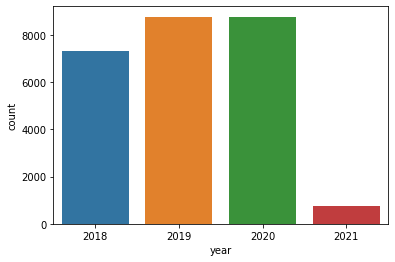

In [ ]:
# 년도별 count
sns.countplot(x='year', data=energy_df)

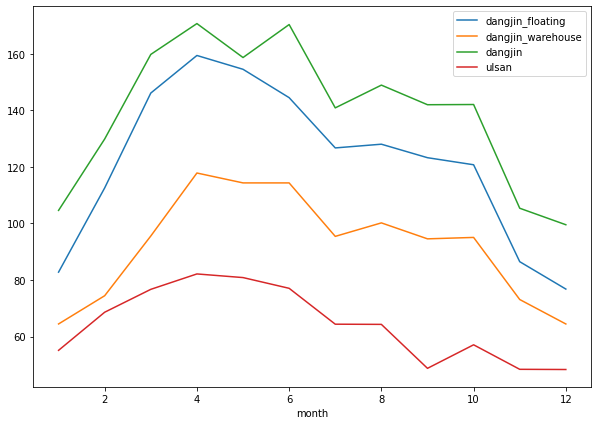

In [ ]:
# 월별 발전량 평균
energy_df.groupby('month')[['dangjin_floating', 'dangjin_warehouse', 'dangjin', 'ulsan']].mean().plot(kind='line', figsize=(10,7))

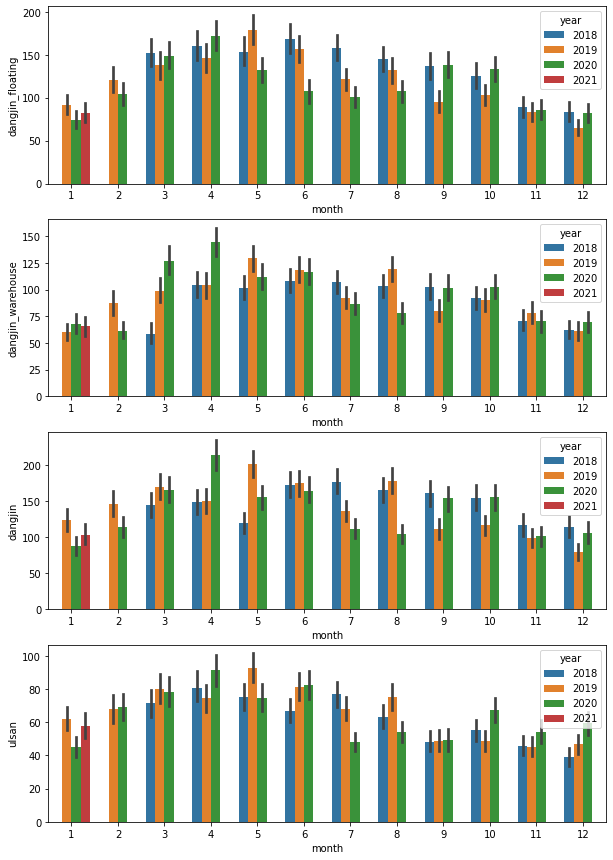

In [ ]:
# 년도별/월별 발전량(KW)
fig, axes = plt.subplots(4, 1)
fig.set_size_inches(10, 15)
sns.barplot(x='month', y='dangjin_floating', hue = 'year', data=energy_df, ax=axes[0])  # 당진수상태양광 발전량(KW)
sns.barplot(x='month', y='dangjin_warehouse', hue = 'year', data=energy_df, ax=axes[1]) # 당진자재창고태양광 발전량(KW)
sns.barplot(x='month', y='dangjin', hue = 'year', data=energy_df, ax=axes[2])           # 당진태양광 발전량(KW)
sns.barplot(x='month', y='ulsan', hue = 'year', data=energy_df, ax=axes[3])             # 울산태양광 발전량(KW)
plt.show()

In [ ]:
# 분기별 데이터 분포
energy_df['quarter'].value_counts()

4    6624
3    6624
2    6552
1    5832
Name: quarter, dtype: int64

In [ ]:
# 분기별 데이터 분포
energy_df['hour'].value_counts()

15    1068
14    1068
16    1068
1     1068
17    1068
2     1068
18    1068
3     1068
19    1068
4     1068
20    1068
5     1068
21    1068
6     1068
22    1068
7     1068
23    1068
8     1068
9     1068
10    1068
11    1068
12    1068
13    1068
0     1068
Name: hour, dtype: int64

In [ ]:
energy_df['minute'].value_counts()

0    25632
Name: minute, dtype: int64

In [ ]:
energy_df['second'].value_counts()

0    25632
Name: second, dtype: int64

In [ ]:
energy_df = energy_df.drop(['minute', 'second'], axis=1)
energy_df.head()

,time,start_time,end_time,dangjin_floating,dangjin_warehouse,dangjin,ulsan,year,month,day,dayofweek,quarter,hour
0,2018-03-01 1:00:00,2018-03-01 00:00:00,2018-03-01 01:00:00,0.0,0.0,0,0,2018,3,1,3,1,0
1,2018-03-01 2:00:00,2018-03-01 01:00:00,2018-03-01 02:00:00,0.0,0.0,0,0,2018,3,1,3,1,1
2,2018-03-01 3:00:00,2018-03-01 02:00:00,2018-03-01 03:00:00,0.0,0.0,0,0,2018,3,1,3,1,2
3,2018-03-01 4:00:00,2018-03-01 03:00:00,2018-03-01 04:00:00,0.0,0.0,0,0,2018,3,1,3,1,3
4,2018-03-01 5:00:00,2018-03-01 04:00:00,2018-03-01 05:00:00,0.0,0.0,0,0,2018,3,1,3,1,4


In [ ]:
# 0: 월요일, 6 일요일
# 주말인 경우: 1, 주중인 경우: 0
energy_df['weekend'] = energy_df['dayofweek'].apply(lambda x: int(x in [5, 6]))
energy_df.head()

,time,start_time,end_time,dangjin_floating,dangjin_warehouse,dangjin,ulsan,year,month,day,dayofweek,quarter,hour,weekend
0,2018-03-01 1:00:00,2018-03-01 00:00:00,2018-03-01 01:00:00,0.0,0.0,0,0,2018,3,1,3,1,0,0
1,2018-03-01 2:00:00,2018-03-01 01:00:00,2018-03-01 02:00:00,0.0,0.0,0,0,2018,3,1,3,1,1,0
2,2018-03-01 3:00:00,2018-03-01 02:00:00,2018-03-01 03:00:00,0.0,0.0,0,0,2018,3,1,3,1,2,0
3,2018-03-01 4:00:00,2018-03-01 03:00:00,2018-03-01 04:00:00,0.0,0.0,0,0,2018,3,1,3,1,3,0
4,2018-03-01 5:00:00,2018-03-01 04:00:00,2018-03-01 05:00:00,0.0,0.0,0,0,2018,3,1,3,1,4,0


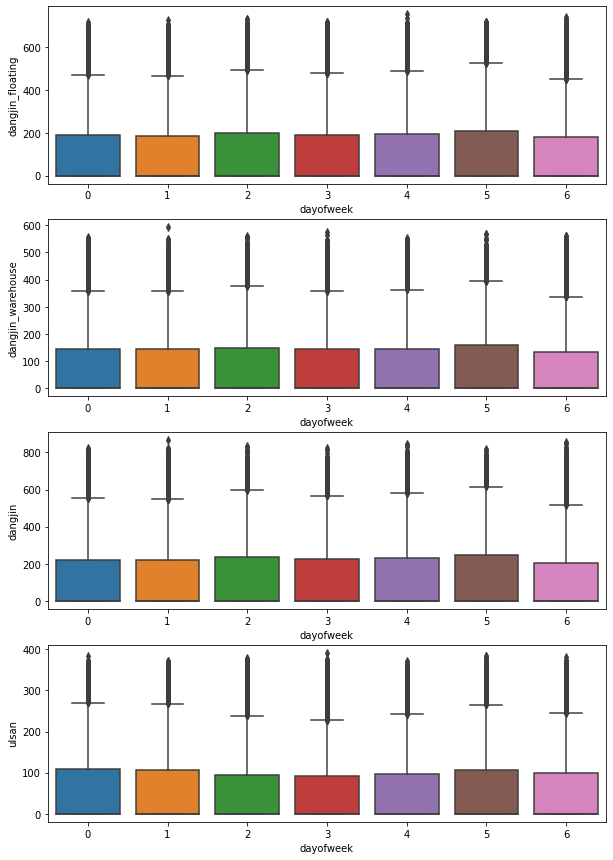

In [ ]:
# 요일별 발전량(KW)

fig, axes = plt.subplots(4, 1)
fig.set_size_inches(10, 15)
sns.boxplot(x='dayofweek', y='dangjin_floating', data=energy_df, ax=axes[0])  # 당진수상태양광 발전량(KW)
sns.boxplot(x='dayofweek', y='dangjin_warehouse', data=energy_df, ax=axes[1]) # 당진자재창고태양광 발전량(KW)
sns.boxplot(x='dayofweek', y='dangjin', data=energy_df, ax=axes[2])           # 당진태양광 발전량(KW)
sns.boxplot(x='dayofweek', y='ulsan', data=energy_df, ax=axes[3])             # 울산태양광 발전량(KW)
plt.show()

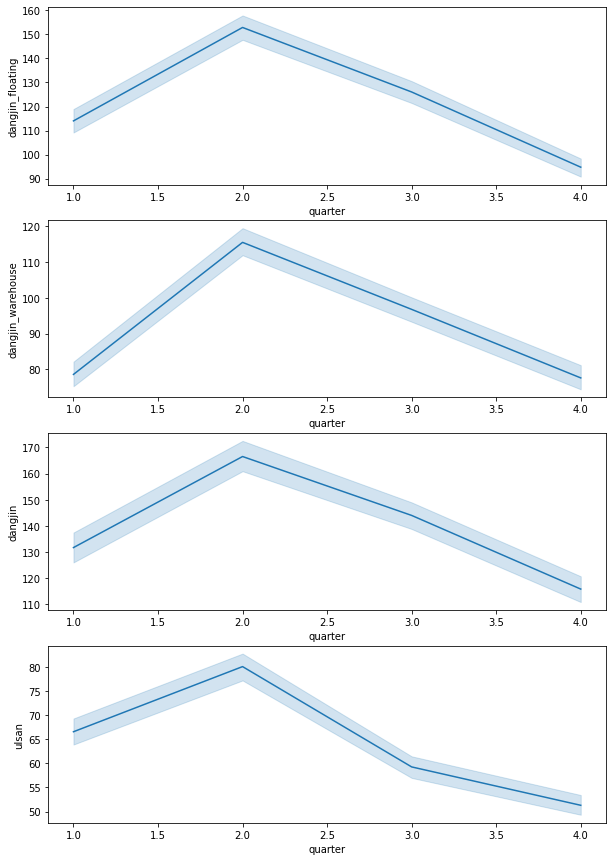

In [ ]:
# 분기별 발전량
power_generations = ['dangjin_floating', 'dangjin_warehouse', 'dangjin', 'ulsan']
draw_line_plot(energy_df, 'quarter', power_generations)

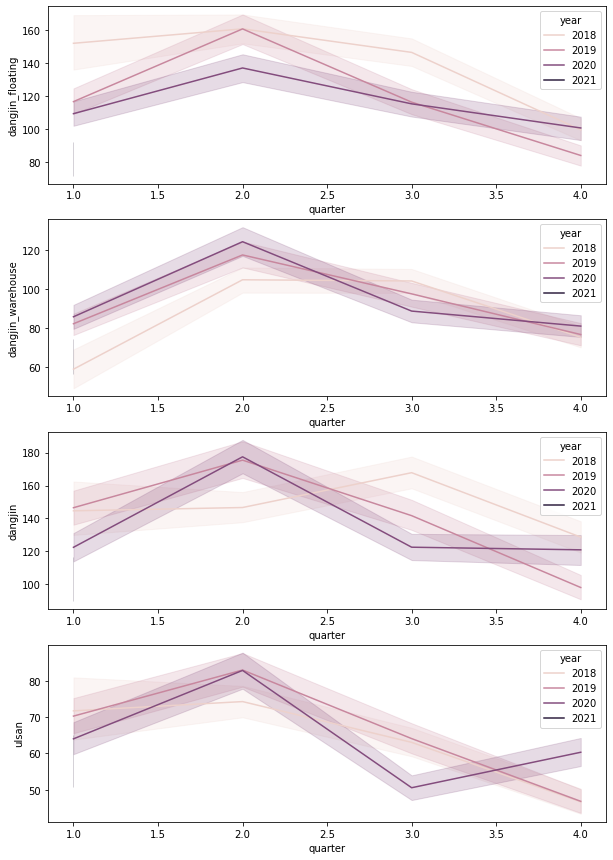

In [ ]:
# 년도별/분기별 발전량
draw_line_plot(energy_df, 'quarter', power_generations, 'year')

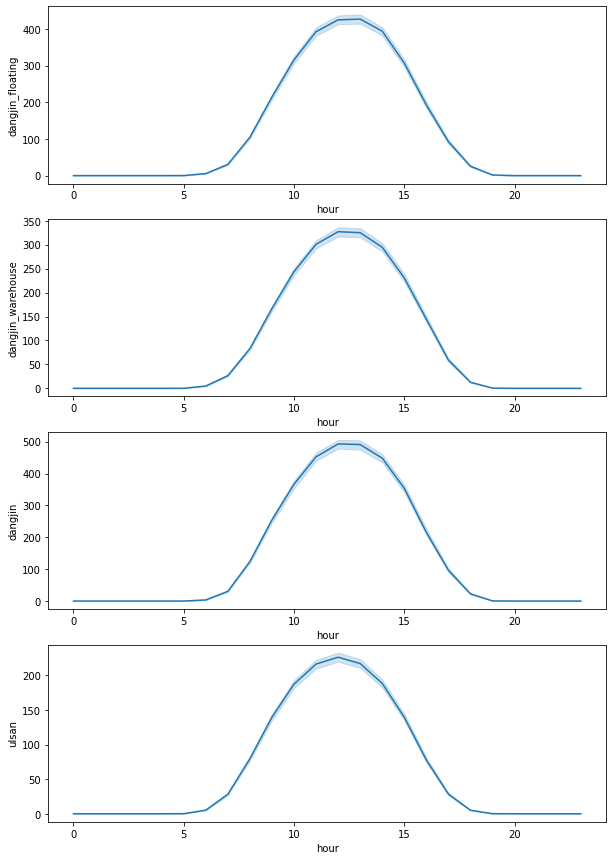

In [ ]:
# 시간별 발전량
draw_line_plot(energy_df, 'hour', power_generations)

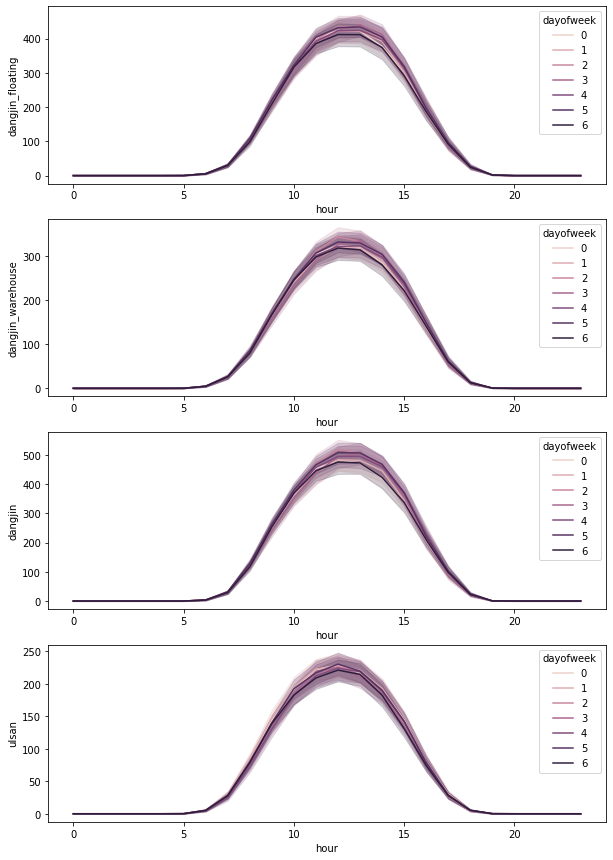

In [ ]:
# 요일별/시간별 발전량
draw_line_plot(energy_df, 'hour', power_generations, hue = 'dayofweek')

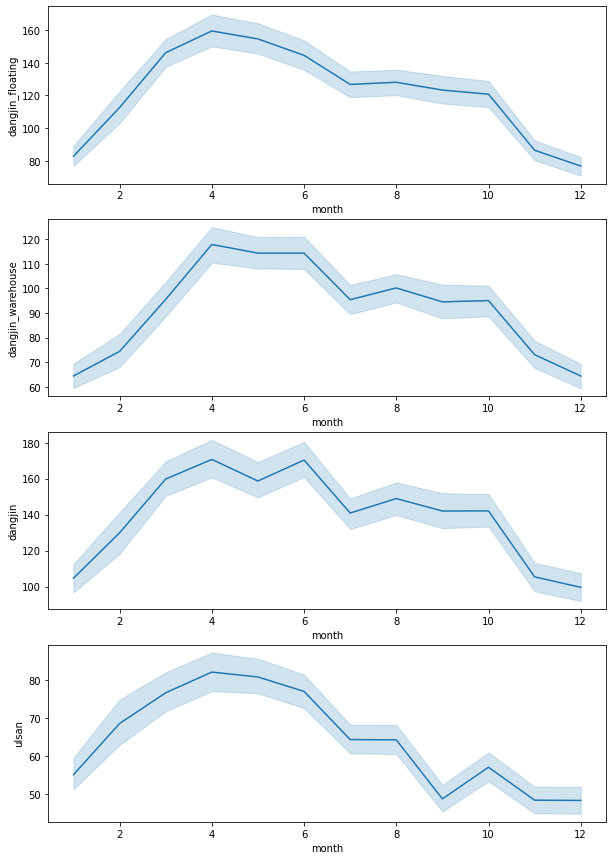

In [ ]:
# 월별 발전량
draw_line_plot(energy_df, 'month', power_generations)

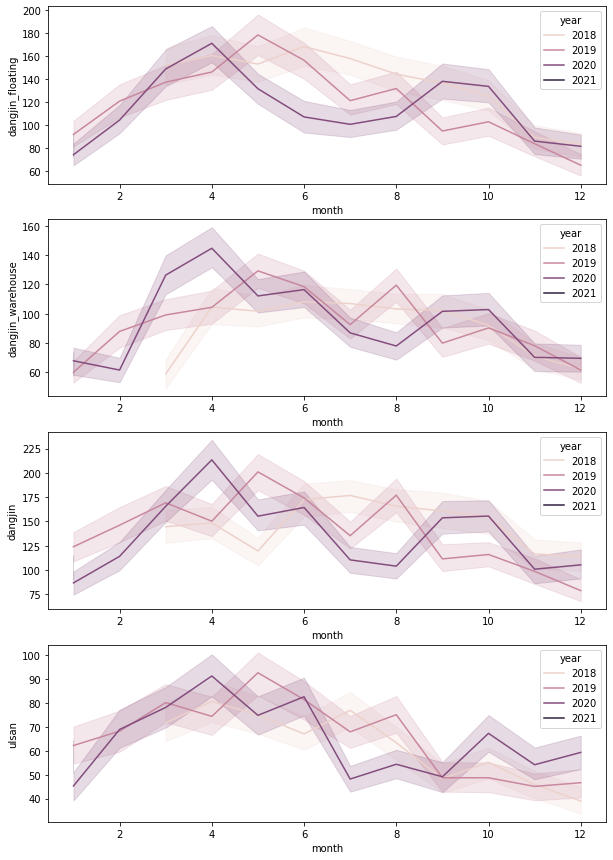

In [ ]:
# 월별/년도별 발전량
draw_line_plot(energy_df, 'month', power_generations, 'year')

## dangjin_fcst_data.csv - 당진지역 발전소 동네 예보
- Forecast time : 예보 발표 시점
- forecast : 예보 시간 (ex - Forecast time:2018-03-01 11:00:00, forecast:4.0 => 2018-03-01 11:00:00에 발표한 2018-03-01 15:00:00 예보

### 예보 발표 시점 'forecast'시간 후 기상 예보
- Temperature : 온도(℃)
- Humidity : 습도(%)
- WindSpeed : 풍속(m/s)
- WindDirection : 풍향(º)
- Cloud : 하늘상태(1-맑음, 2-구름보통, 3-구름많음, 4-흐림)

In [ ]:
dangjin_fcst_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162208 entries, 0 to 162207
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Forecast time  162208 non-null  object 
 1   forecast       162208 non-null  float64
 2   Temperature    162208 non-null  float64
 3   Humidity       162208 non-null  float64
 4   WindSpeed      162208 non-null  float64
 5   WindDirection  162208 non-null  float64
 6   Cloud          162208 non-null  float64
dtypes: float64(6), object(1)
memory usage: 8.7+ MB


In [ ]:
dangjin_fcst_df

,Forecast time,forecast,Temperature,Humidity,WindSpeed,WindDirection,Cloud
0,2018-03-01 11:00:00,4.0,0.0,60.0,7.3,309.0,2.0
1,2018-03-01 11:00:00,7.0,-2.0,60.0,7.1,314.0,1.0
2,2018-03-01 11:00:00,10.0,-2.0,60.0,6.7,323.0,1.0
3,2018-03-01 11:00:00,13.0,-2.0,55.0,6.7,336.0,1.0
4,2018-03-01 11:00:00,16.0,-4.0,55.0,5.5,339.0,1.0
...,...,...,...,...,...,...,...
162203,2021-03-01 08:00:00,52.0,7.0,40.0,3.2,187.0,1.0
162204,2021-03-01 08:00:00,55.0,8.0,40.0,4.5,217.0,1.0
162205,2021-03-01 08:00:00,58.0,5.0,55.0,2.2,210.0,1.0
162206,2021-03-01 08:00:00,61.0,1.0,80.0,1.9,164.0,1.0


In [ ]:
dangjin_feb_temperature_df = pd.read_csv('./data/dangjin/석문면_3시간기온_201802_201802.csv')
dangjin_feb_humidity_df = pd.read_csv('./data/dangjin/석문면_습도_201802_201802.csv')
dangjin_feb_wind_direction_df = pd.read_csv('./data/dangjin/석문면_풍향_201802_201802.csv')
dangjin_feb_wind_speed_df = pd.read_csv('./data/dangjin/석문면_풍속_201802_201802.csv')
dangjin_feb_cloud_df = pd.read_csv('./data/dangjin/석문면_하늘상태_201802_201802.csv')

In [ ]:
# 2018-02-28의 14시 예보만 사용
dangjin_feb_temperature_df = dangjin_feb_temperature_df[(dangjin_feb_temperature_df[' format: day'] == 28) & (dangjin_feb_temperature_df['hour'] == 1400)]
dangjin_feb_humidity_df = dangjin_feb_humidity_df[(dangjin_feb_humidity_df[' format: day'] == 28) & (dangjin_feb_humidity_df['hour'] == 1400)]
dangjin_feb_wind_direction_df = dangjin_feb_wind_direction_df[(dangjin_feb_wind_direction_df[' format: day'] == 28) & (dangjin_feb_wind_direction_df['hour'] == 1400)]
dangjin_feb_wind_speed_df = dangjin_feb_wind_speed_df[(dangjin_feb_wind_speed_df[' format: day'] == 28) & (dangjin_feb_wind_speed_df['hour'] == 1400)]
dangjin_feb_cloud_df = dangjin_feb_cloud_df[(dangjin_feb_cloud_df[' format: day'] == 28) & (dangjin_feb_cloud_df['hour'] == 1400)]

def make_feb_fcst_df(df, key):
    df[key] = df.iloc[:,-1:].astype(float)
    df['Forecast time'] = pd.to_datetime('2018-02-28 14:00:00')
    df['forecast'] = df['forecast'].astype(float)

    return df[['Forecast time', 'forecast', key]]

dangjin_feb_temperature_df = make_feb_fcst_df(dangjin_feb_temperature_df, 'Temperature')
dangjin_feb_humidity_df = make_feb_fcst_df(dangjin_feb_humidity_df, 'Humidity')
dangjin_feb_wind_direction_df = make_feb_fcst_df(dangjin_feb_wind_direction_df, 'WindDirection')
dangjin_feb_wind_speed_df = make_feb_fcst_df(dangjin_feb_wind_speed_df, 'WindSpeed')
dangjin_feb_cloud_df = make_feb_fcst_df(dangjin_feb_cloud_df, 'Cloud')


In [ ]:
dfs = [dangjin_feb_temperature_df, dangjin_feb_humidity_df, dangjin_feb_wind_direction_df, dangjin_feb_wind_speed_df, dangjin_feb_cloud_df]
dangjin_feb_fcst_df = reduce(lambda df_left, df_right: pd.merge(df_left, df_right, how = 'left'), dfs)

In [ ]:
# 2018-02-28 14시 예보 추가
dangjin_fcst_df = pd.concat([dangjin_feb_fcst_df, dangjin_fcst_df])

In [ ]:
"""
- DACON.Dobby님의 소스를 참고하였습니다.
- https://dacon.io/competitions/official/235720/codeshare/2499?page=1&dtype=recent
"""
def make_fcst_df(df):
    df['Forecast time'] = pd.to_datetime(df['Forecast time'])

    # 14시 예보만 사용
    fcst_14_df = df[df['Forecast time'].dt.hour == 14]

    # 다음 날의 기상 예보가 필요하여 예보시간 기준 10시간 후(00:00)부터 33시간 후(23:00) 데이터만 사용
    fcst_14_df = fcst_14_df[(fcst_14_df['forecast'] >= 10) & (fcst_14_df['forecast'] <= 33)]

    # 예보 시점에 focast를 더하여 예보 시각을 구한다.
    fcst_14_df['Forecast_time'] = fcst_14_df['Forecast time'] + fcst_14_df['forecast'].map(lambda x: pd.DateOffset(hours=x))

    # 풍향을 radian으로
    # fcst_14_df['WindDirection_Rad'] = fcst_14_df['WindDirection'] * np.pi / 180

    fcst_14_df =  fcst_14_df[['Forecast_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']]

    # 태양광 발전량 예측은 1시간 간격으로 해야하나 예보는 3시간 간격으로 나오기 떄문에 선형보간법을 활용하여 비어있는 값을 채운다
    # 한시간 간격의 데이터프레임을 생성
    fcst_14_df_ = pd.DataFrame()
    fcst_14_df_['Forecast_time'] = pd.date_range(start='2018-03-01 00:00:00', end='2021-03-01 23:00:00', freq='H')

    # 기존 예보 df와 병합
    fcst_14_df_ = pd.merge(fcst_14_df_, fcst_14_df, on='Forecast_time', how='outer')

    # 선형보간
    inter_fcst_14_df = fcst_14_df_.interpolate()

    return inter_fcst_14_df
    

In [ ]:
# 선형보간
inter_dangjin_fcst_14_df = make_fcst_df(dangjin_fcst_df)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


## ulsan_fcst_data.csv - 울산지역 발전소 동네 예보
- Forecast time : 예보 발표 시점
- forecast : 예보 시간 (ex - Forecast time:2018-03-01 11:00:00, forecast:4.0 => 2018-03-01 11:00:00에 발표한 2018-03-01 15:00:00 예보

### 예보 발표 시점 'forecast'시간 후 기상 예보
- Temperature : 온도(℃)
- Humidity : 습도(%)
- WindSpeed : 풍속(m/s)
- WindDirection : 풍향(º)
- Cloud : 하늘상태(1-맑음, 2-구름보통, 3-구름많음, 4-흐림)

In [ ]:
ulsan_fcst_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162208 entries, 0 to 162207
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Forecast time  162208 non-null  object 
 1   forecast       162208 non-null  float64
 2   Temperature    162208 non-null  float64
 3   Humidity       162208 non-null  float64
 4   WindSpeed      162208 non-null  float64
 5   WindDirection  162208 non-null  float64
 6   Cloud          162208 non-null  float64
dtypes: float64(6), object(1)
memory usage: 8.7+ MB


In [ ]:
ulsan_feb_temperature_df = pd.read_csv('./data/ulsan/선암동_3시간기온_201802_201802.csv')
ulsan_feb_humidity_df = pd.read_csv('./data/ulsan/선암동_습도_201802_201802.csv')
ulsan_feb_wind_direction_df = pd.read_csv('./data/ulsan/선암동_풍향_201802_201802.csv')
ulsan_feb_wind_speed_df = pd.read_csv('./data/ulsan/선암동_풍속_201802_201802.csv')
ulsan_feb_cloud_df = pd.read_csv('./data/ulsan/선암동_하늘상태_201802_201802.csv')

In [ ]:
ulsan_feb_temperature_df = ulsan_feb_temperature_df[(ulsan_feb_temperature_df[' format: day'] == 28) & (ulsan_feb_temperature_df['hour'] == 1400)]
ulsan_feb_humidity_df = ulsan_feb_humidity_df[(ulsan_feb_humidity_df[' format: day'] == 28) & (ulsan_feb_humidity_df['hour'] == 1400)]
ulsan_feb_wind_direction_df = ulsan_feb_wind_direction_df[(ulsan_feb_wind_direction_df[' format: day'] == 28) & (ulsan_feb_wind_direction_df['hour'] == 1400)]
ulsan_feb_wind_speed_df = ulsan_feb_wind_speed_df[(ulsan_feb_wind_speed_df[' format: day'] == 28) & (ulsan_feb_wind_speed_df['hour'] == 1400)]
ulsan_feb_cloud_df = ulsan_feb_cloud_df[(ulsan_feb_cloud_df[' format: day'] == 28) & (ulsan_feb_cloud_df['hour'] == 1400)]

ulsan_feb_temperature_df = make_feb_fcst_df(ulsan_feb_temperature_df, 'Temperature')
ulsan_feb_humidity_df = make_feb_fcst_df(ulsan_feb_humidity_df, 'Humidity')
ulsan_feb_wind_direction_df = make_feb_fcst_df(ulsan_feb_wind_direction_df, 'WindDirection')
ulsan_feb_wind_speed_df = make_feb_fcst_df(ulsan_feb_wind_speed_df, 'WindSpeed')
ulsan_feb_cloud_df = make_feb_fcst_df(ulsan_feb_cloud_df, 'Cloud')

In [ ]:
dfs = [ulsan_feb_temperature_df, ulsan_feb_humidity_df, ulsan_feb_wind_direction_df, ulsan_feb_wind_speed_df, ulsan_feb_cloud_df]
ulsan_feb_fcst_df = reduce(lambda df_left, df_right: pd.merge(df_left, df_right, how = 'left'), dfs)

In [ ]:
# 2018-02-28 14시 예보 추가
ulsan_fcst_df = pd.concat([ulsan_feb_fcst_df, ulsan_fcst_df])

In [ ]:
# # 선형보간
inter_ulsan_fcst_14_df = make_fcst_df(ulsan_fcst_df)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


## 학습데이터 전처리
### 1. 기상정보와 발전량 merge
### 2. 결측치 확인 및 fillna
### 3. 발전량이 0인 데이터 제거
### 4. 시간 데이터 전처리

In [ ]:
energy_df

,time,start_time,end_time,dangjin_floating,dangjin_warehouse,dangjin,ulsan,year,month,day,dayofweek,quarter,hour,weekend
0,2018-03-01 1:00:00,2018-03-01 00:00:00,2018-03-01 01:00:00,0.0,0.0,0,0,2018,3,1,3,1,0,0
1,2018-03-01 2:00:00,2018-03-01 01:00:00,2018-03-01 02:00:00,0.0,0.0,0,0,2018,3,1,3,1,1,0
2,2018-03-01 3:00:00,2018-03-01 02:00:00,2018-03-01 03:00:00,0.0,0.0,0,0,2018,3,1,3,1,2,0
3,2018-03-01 4:00:00,2018-03-01 03:00:00,2018-03-01 04:00:00,0.0,0.0,0,0,2018,3,1,3,1,3,0
4,2018-03-01 5:00:00,2018-03-01 04:00:00,2018-03-01 05:00:00,0.0,0.0,0,0,2018,3,1,3,1,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25627,2021-01-31 20:00:00,2021-01-31 19:00:00,2021-01-31 20:00:00,0.0,0.0,0,0,2021,1,31,6,1,19,1
25628,2021-01-31 21:00:00,2021-01-31 20:00:00,2021-01-31 21:00:00,0.0,0.0,0,0,2021,1,31,6,1,20,1
25629,2021-01-31 22:00:00,2021-01-31 21:00:00,2021-01-31 22:00:00,0.0,0.0,0,0,2021,1,31,6,1,21,1
25630,2021-01-31 23:00:00,2021-01-31 22:00:00,2021-01-31 23:00:00,0.0,0.0,0,0,2021,1,31,6,1,22,1


In [ ]:
energy_df = energy_df[['time', 'start_time', 'end_time', 'dangjin_floating', 'dangjin_warehouse', 'dangjin', 'ulsan']]

In [ ]:
dangjin_floating_df = energy_df.iloc[:, [0, 1, 2, 3]]
dangjin_warehouse_df = energy_df.iloc[:, [0, 1, 2, 4]]
dangjin_df = energy_df.iloc[:, [0, 1, 2, 5]]
ulsan_df = energy_df.iloc[:, [0, 1, 2, 6]]

In [ ]:
columns = ['time', 'start_time', 'end_time', 'Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud']

# 기상정보와 발전량 merge
dangjin_floating_df = pd.concat([dangjin_floating_df, inter_dangjin_fcst_14_df],axis=1, join='inner')[columns + ['dangjin_floating']]
dangjin_warehouse_df = pd.concat([dangjin_warehouse_df, inter_dangjin_fcst_14_df],axis=1, join='inner')[columns + ['dangjin_warehouse']]
dangjin_df = pd.concat([dangjin_df, inter_dangjin_fcst_14_df],axis=1, join='inner')[columns + ['dangjin']]
ulsan_df = pd.concat([ulsan_df, inter_dangjin_fcst_14_df],axis=1, join='inner')[columns + ['ulsan']]

In [ ]:
# 결측치 확인
display(dangjin_floating_df['dangjin_floating'].isnull().sum())
display(dangjin_warehouse_df['dangjin_warehouse'].isnull().sum())
display(dangjin_df['dangjin'].isnull().sum()) # 결측치 없음
display(ulsan_df['ulsan'].isnull().sum()) # 결측치 없음

24

48

0

0

In [ ]:
def set_missing_value_group_by_time(df, key):
    df[key] = df.groupby(df.start_time.dt.time, sort=False)[key].apply(lambda x: x.fillna(x.mean()))
    return df

def filter_zero(df, key):
    df = df[df[key] != 0]
    return df

In [ ]:
# 결측치는 시간별 평균 값으로 채움
dangjin_floating_df = set_missing_value_group_by_time(dangjin_floating_df, 'dangjin_floating')
dangjin_warehouse_df = set_missing_value_group_by_time(dangjin_warehouse_df, 'dangjin_warehouse')

In [ ]:
# 발전량이 0인 데이터 제거
dangjin_floating_df = filter_zero(dangjin_floating_df, 'dangjin_floating')
dangjin_warehouse_df = filter_zero(dangjin_warehouse_df, 'dangjin_warehouse')
dangjin_df = filter_zero(dangjin_df, 'dangjin')
ulsan_df = filter_zero(ulsan_df, 'ulsan')

In [ ]:
dangjin_floating_df

,time,start_time,end_time,Temperature,Humidity,WindSpeed,WindDirection,Cloud,dangjin_floating
8,2018-03-01 9:00:00,2018-03-01 08:00:00,2018-03-01 09:00:00,-0.666667,63.333333,7.133333,311.666667,1.333333,36.0
9,2018-03-01 10:00:00,2018-03-01 09:00:00,2018-03-01 10:00:00,-1.000000,65.000000,7.100000,313.000000,1.000000,313.0
10,2018-03-01 11:00:00,2018-03-01 10:00:00,2018-03-01 11:00:00,-1.333333,63.333333,7.133333,319.000000,1.000000,532.0
11,2018-03-01 12:00:00,2018-03-01 11:00:00,2018-03-01 12:00:00,-1.666667,61.666667,7.166667,325.000000,1.000000,607.0
12,2018-03-01 13:00:00,2018-03-01 12:00:00,2018-03-01 13:00:00,-2.000000,60.000000,7.200000,331.000000,1.000000,614.0
...,...,...,...,...,...,...,...,...,...
25621,2021-01-31 14:00:00,2021-01-31 13:00:00,2021-01-31 14:00:00,8.333333,46.666667,4.400000,177.333333,3.333333,397.0
25622,2021-01-31 15:00:00,2021-01-31 14:00:00,2021-01-31 15:00:00,8.666667,53.333333,4.200000,180.666667,3.666667,297.0
25623,2021-01-31 16:00:00,2021-01-31 15:00:00,2021-01-31 16:00:00,9.000000,60.000000,4.000000,184.000000,4.000000,230.0
25624,2021-01-31 17:00:00,2021-01-31 16:00:00,2021-01-31 17:00:00,8.000000,65.000000,3.700000,180.666667,4.000000,76.0


In [ ]:
# 시간데이터 전처리
import time
import numpy as np

def set_normalize_time(df, key):
    day = 24 * 60 * 60
    year = (365.2425) * day

    timestamp_s = df['start_time'].map(lambda x: time.mktime(pd.Timestamp(x).timetuple()))

    df['Day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
    df['Year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

    return df[['Temperature', 'Humidity', 'WindSpeed', 'WindDirection', 'Cloud', 'Day_sin', 'Day_cos', 'Year_sin', 'Year_cos', key]]

dangjin_floating_df = set_normalize_time(dangjin_floating_df, 'dangjin_floating')
dangjin_warehouse_df = set_normalize_time(dangjin_warehouse_df, 'dangjin_warehouse')
dangjin_df = set_normalize_time(dangjin_df, 'dangjin')
ulsan_df = set_normalize_time(ulsan_df, 'ulsan')

In [ ]:
# 데이터 분할 및 정규화
def split_df(df):
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]

    train_x = train_df.iloc[:, :-2]
    train_y = train_df.iloc[:,-1:]

    val_x = val_df.iloc[:, :-2]
    val_y = val_df.iloc[:, -1:]

    test_x = test_df.iloc[:, :-2]
    test_y = test_df.iloc[:, -1:]

    train_mean = train_x.mean()
    train_std = train_x.std()

    train_x = (train_x - train_mean) / train_std
    val_x = (val_x - train_mean) / train_std
    test_x = (test_x - train_mean) / train_std

    return train_x, train_y, val_x, val_y, test_x, test_y

In [ ]:
train_x, train_y, val_x, val_y, test_x, test_y = split_df(dangjin_floating_df)

In [ ]:
train_x.shape

(8872, 8)

In [ ]:
train_y.shape

(8872, 1)

In [ ]:
# 데이터셋 생성
import tensorflow as tf

WINDOW_SIZE = 24 * 30
BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 0.0005

def windowed_dataset(x, y, window_size, batch_size, shuffle, target):
    # X 데이터
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift = 1, stride = 1, drop_remainder = True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))

    # Y 데이터
    ds_y = tf.data.Dataset.from_tensor_slices(y[target][window_size:])

    # zip
    ds = tf.data.Dataset.zip((ds_x, ds_y))

    if shuffle:
        ds = ds.shuffle(1000)
    
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_data = windowed_dataset(train_x, train_y, WINDOW_SIZE, BATCH_SIZE, True, 'dangjin_floating')
val_data = windowed_dataset(val_x, val_y, WINDOW_SIZE, BATCH_SIZE, False, 'dangjin_floating')

In [ ]:
for x, y in train_data.take(1):
    print(x.shape)

(32, 720, 8)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, GRU, Bidirectional, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True, dropout=0.5, input_shape = (None, 8, ))),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.5, input_shape = (None, 8, ))),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.5, input_shape = (None, 8, ))),
    Bidirectional(LSTM(64, dropout=0.5)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(1)
])
# model.add(LSTM(22, input_shape = (None, 8, )))
# model.add(GRU(512, return_sequences=True, input_shape=(None, 8,)))
        
# model.add(Dense(1))

In [ ]:
loss = Huber()
optimizer = Adam(LEARNING_RATE)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mae'])

In [ ]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
early_stopping = EarlyStopping(monitor='val_loss', patience=100)

# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(
    filename, 
    save_weights_only=True, 
    save_best_only=True, 
    monitor='val_loss', 
    verbose=1
)

In [ ]:
history = model.fit(
    train_data, 
    validation_data = (val_data), 
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/200
255/255 [==============================] - 88s 297ms/step - loss: 259.6081 - mae: 260.1073 - val_loss: 182.3777 - val_mae: 182.8764

Epoch 00001: val_loss improved from inf to 182.37769, saving model to tmp/ckeckpointer.ckpt
Epoch 2/200
255/255 [==============================] - 74s 290ms/step - loss: 233.7605 - mae: 234.2600 - val_loss: 182.5885 - val_mae: 183.0879

Epoch 00002: val_loss did not improve from 182.37769
Epoch 3/200
255/255 [==============================] - 75s 293ms/step - loss: 228.3558 - mae: 228.8551 - val_loss: 175.1403 - val_mae: 175.6398

Epoch 00003: val_loss improved from 182.37769 to 175.14034, saving model to tmp/ckeckpointer.ckpt
Epoch 4/200
255/255 [==============================] - 76s 295ms/step - loss: 207.4380 - mae: 207.9357 - val_loss: 130.2410 - val_mae: 130.7391

Epoch 00004: val_loss improved from 175.14034 to 130.24103, saving model to tmp/ckeckpointer.ckpt
Epoch 5/200
255/255 [==============================] - 75s 295ms/step - loss: 1